#### `Import Libraries`

In [17]:
import pandas as pd
import numpy as np
import os
import mlflow
import warnings
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

warnings.filterwarnings('ignore')
%matplotlib inline

In [18]:
!python --version

Python 3.8.5


#### `Loading Dataset`

In [19]:
filepath = os.getcwd() + "/Play_Tennis.csv"
df = pd.read_csv(filepath).drop("Day", axis=1)
# df.head()
display(df.head(5))
display(df.tail(5))

,Outlook,Temprature,Humidity,Wind,Play_Tennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


,Outlook,Temprature,Humidity,Wind,Play_Tennis
9,Rain,Mild,Normal,Weak,Yes
10,Sunny,Mild,Normal,Strong,Yes
11,Overcast,Mild,High,Strong,Yes
12,Overcast,Hot,Normal,Weak,Yes
13,Rain,Mild,High,Strong,No


#### `Descriptive Stats`

In [20]:
print(df.info())
print('\nMissing values in given data :')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Outlook      14 non-null     object
 1   Temprature   14 non-null     object
 2   Humidity     14 non-null     object
 3   Wind         14 non-null     object
 4   Play_Tennis  14 non-null     object
dtypes: object(5)
memory usage: 688.0+ bytes
None

Missing values in given data :
Outlook        0
Temprature     0
Humidity       0
Wind           0
Play_Tennis    0
dtype: int64


In [21]:
df.describe()

,Outlook,Temprature,Humidity,Wind,Play_Tennis
count,14,14,14,14,14
unique,3,3,2,2,2
top,Sunny,Mild,High,Weak,Yes
freq,5,6,7,8,9


#### Dummy Variables Creation<span style='background:yellow'>(Instead of direct categorical variable, sklearn library works with encoded category variables to find Entropy and I.G for best splits)</span>

In [22]:
df_dummy = pd.get_dummies(data = df, columns=['Outlook','Temprature','Humidity','Wind'])
df_dummy.head()

,Play_Tennis,Outlook_Overcast,Outlook_Rain,Outlook_Sunny,Temprature_Cool,Temprature_Hot,Temprature_Mild,Humidity_High,Humidity_Normal,Wind_Strong,Wind_Weak
0,No,0,0,1,0,1,0,1,0,0,1
1,No,0,0,1,0,1,0,1,0,1,0
2,Yes,1,0,0,0,1,0,1,0,0,1
3,Yes,0,1,0,0,0,1,1,0,0,1
4,Yes,0,1,0,1,0,0,0,1,0,1


#### `Train & Test split`

In [23]:
X = df_dummy.drop(['Play_Tennis'],axis=1)
y = df_dummy['Play_Tennis']

y = np.where(y=='Yes', 1, 0)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 101 )

In [25]:
# https://stackoverflow.com/questions/46364047/convert-uint8-to-int64-in-python

print("--"*10)
print("Before : DataTypes")
print("--"*10)
display(X_test.dtypes)
X_test = X_test.applymap(lambda x: int(x))
print("--"*10)
print("After : DataTypes")
print("--"*10)
display(X_test.dtypes)

# display(X_train.dtypes)
X_train = X_train.applymap(lambda x: int(x))
# display(X_train.dtypes)

--------------------
Before : DataTypes
--------------------


Outlook_Overcast    uint8
Outlook_Rain        uint8
Outlook_Sunny       uint8
Temprature_Cool     uint8
Temprature_Hot      uint8
Temprature_Mild     uint8
Humidity_High       uint8
Humidity_Normal     uint8
Wind_Strong         uint8
Wind_Weak           uint8
dtype: object

--------------------
After : DataTypes
--------------------


Outlook_Overcast    int64
Outlook_Rain        int64
Outlook_Sunny       int64
Temprature_Cool     int64
Temprature_Hot      int64
Temprature_Mild     int64
Humidity_High       int64
Humidity_Normal     int64
Wind_Strong         int64
Wind_Weak           int64
dtype: object

#### `Basic Hyperparameters`

In [26]:
rtree = RandomForestClassifier(criterion='gini', max_depth=3, max_features=2, n_estimators=19)
rtree

RandomForestClassifier(max_depth=3, max_features=2, n_estimators=19)

#### `Model Fit`

In [27]:
rtree.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features=2, n_estimators=19)

#### `MLflow Experiment`

In [30]:
# Create Experiment in MLflow
mlflow.set_experiment("Play_Tennis_Classifier_Model")
experiment = mlflow.get_experiment_by_name("Play_Tennis_Classifier_Model")

2022/03/20 08:46:57 INFO mlflow.tracking.fluent: Experiment with name 'Play_Tennis_Classifier_Model' does not exist. Creating a new experiment.


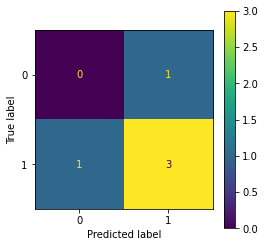

In [32]:
with mlflow.start_run(experiment_id=experiment.experiment_id):
    ##### Predictions
    y_pred = rtree.predict(X_test)
    ##### Model Performance on Test Data
    conf_matrix = confusion_matrix(y_test, y_pred)
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    ##### Model Metrics into MLflow
    mlflow.log_metric("True Negatives", TN)
    mlflow.log_metric("False Postives", FP)
    mlflow.log_metric("False Negatives", FN)
    mlflow.log_metric("True Positives", TP)
    mlflow.sklearn.log_model(rtree, "Play_Tennis_RFC")
    ##### Storing Train, Test Data into Local Drive & MLflow Artifact
    data_path = os.getcwd() + "/Data"
    X_train.to_csv("X_train.csv", encoding="utf-8", index=False)
    pd.Series(y_train).to_csv("y_train.csv", encoding="utf-8", index=False)
    X_test.to_csv("X_test.csv", encoding="utf-8", index=False)
    pd.Series(y_test).to_csv("y_test.csv", encoding="utf-8", index=False)
    ##### Model Data into MLflow
    mlflow.log_artifact("X_train.csv")
    mlflow.log_artifact("y_train.csv")
    mlflow.log_artifact("X_test.csv")
    mlflow.log_artifact("y_test.csv")
    ##### Confusion Matrix Plot into Local Drive & MLflow Artifact
    fig, axes = plt.subplots(1,1,figsize=(4,4))
    metrics.plot_confusion_matrix(rtree, X_test, y_test, ax=axes)
    mlflow.log_figure(fig, "confusion_matrix.png")

#### `Start MLflow UI[Model Results - Sharing & Tracking]`

![](Readme_Images/Start_MLflow_UI.png)

#### `MLRuns`

![](Readme_Images/mlruns.png)

#### `MLflow Experiments`

![](Readme_Images/MLflow_Experiments.png)

#### `MLflow Experiment`

![](Readme_Images/MLflow_Experiment.png)

#### `Artifacts`

![](Readme_Images/Artifacts.png)

#### `Artifact Model`

![](Readme_Images/Artifact_Model.png)

#### `Conda.yaml`

![](Readme_Images/Conda_yaml.png)

#### `Confusion Matrix`

![](Readme_Images/Confusion_Matrix.png)

#### `MLModel`

![](Readme_Images/MLModel.png)

#### `Model_Data`

![](Readme_Images/Model_Data.png)

#### `Requirements`

![](Readme_Images/Requirements.png)

#### `Serve MLflow[Model For Predictions]`

![](Readme_Images/Model_Serve_1.png)
![](Readme_Images/Model_Serve_2.png)

#### `Model Predictions Request`

![](Readme_Images/Post_Request_1.png)
![](Readme_Images/Post_Request_2.png)